In [7]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Explainability

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



[Attention] Method: dot, Backend: xformers
[Attention] xformers version: 0.0.30
[Attention] FlashAttention version: 2.7.4.post1


Training: 100%|██████████| 100/100 [00:04<00:00, 21.04epoch/s, train_loss=0.00968, val_loss=N/A, lr=0.001]


Validation Forecast Error Metrics:
  MSE   = 0.010991
  RMSE  = 0.104839
  MAE   = 0.086090


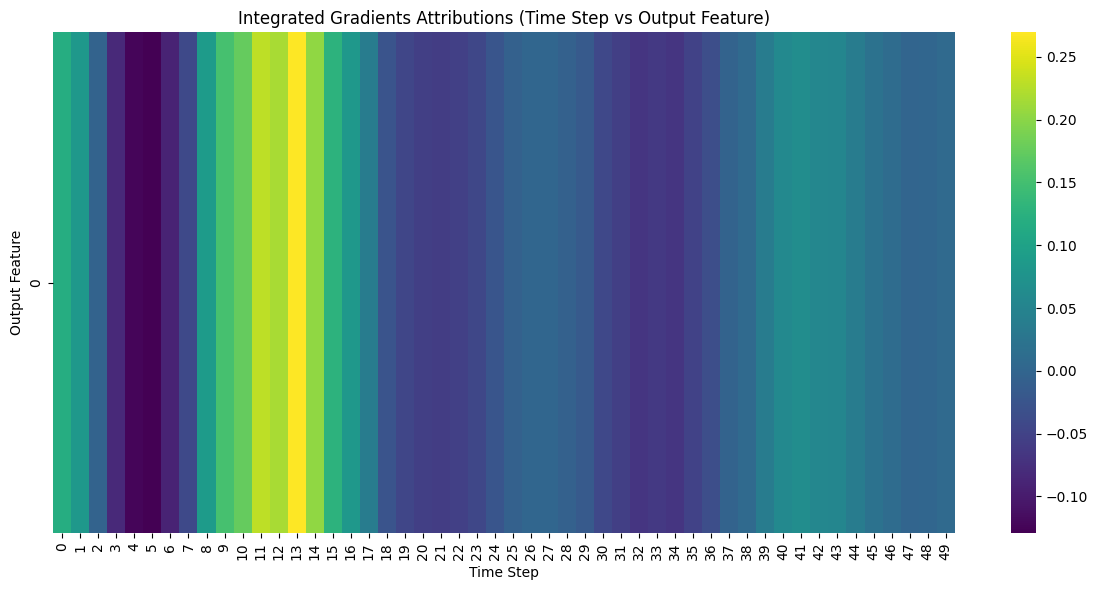

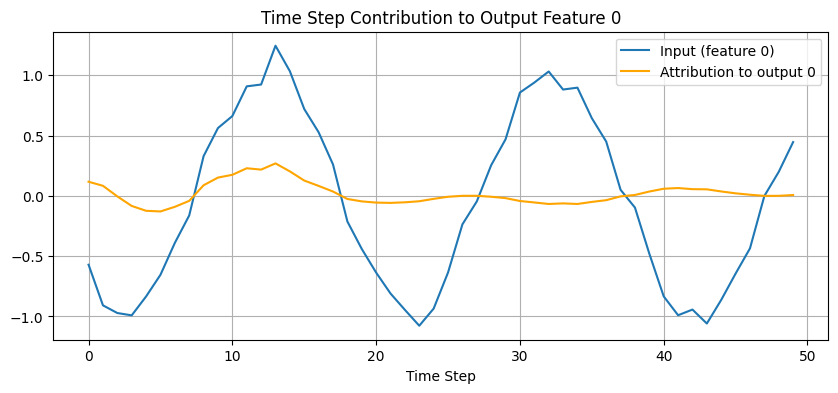

In [12]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

# Prepare input
input_tensor = X_val[0].unsqueeze(0).to('cuda').requires_grad_()  # [1, seq_len, input_size]

# Set model to training mode (to allow RNN backward) but freeze dropout
model.train()
model._disable_dropout()

# Define forward function
forward_fn = partial(model.attribute_forward, time_features=None, targets=None, epoch=None)

# Attribution method
ig = IntegratedGradients(forward_fn)

# Choose target output feature (e.g., output dimension 0)
target_index = 0

# Compute attributions
attributions = ig.attribute(input_tensor, target=target_index)  # Shape: [1, seq_len, output_size]

# Convert to NumPy
attributions_np = attributions.squeeze(0).detach().cpu().numpy()  # [seq_len, output_size]
input_np = input_tensor.squeeze(0).detach().cpu().numpy()         # [seq_len, input_size]

plt.figure(figsize=(12, 6))
sns.heatmap(attributions_np.T, cmap='viridis', xticklabels=True, yticklabels=True)
plt.xlabel("Time Step")
plt.ylabel("Output Feature")
plt.title("Integrated Gradients Attributions (Time Step vs Output Feature)")
plt.tight_layout()
plt.show()

output_feature_idx = 0
plt.figure(figsize=(10, 4))
plt.plot(input_np[:, 0], label="Input (feature 0)")
plt.plot(attributions_np[:, output_feature_idx], label="Attribution to output 0", color="orange")
plt.xlabel("Time Step")
plt.legend()
plt.title("Time Step Contribution to Output Feature 0")
plt.grid(True)
plt.show()

